In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import secrets
import math

In [4]:
image = np.array(Image.open("images/dog.png").convert("L"))

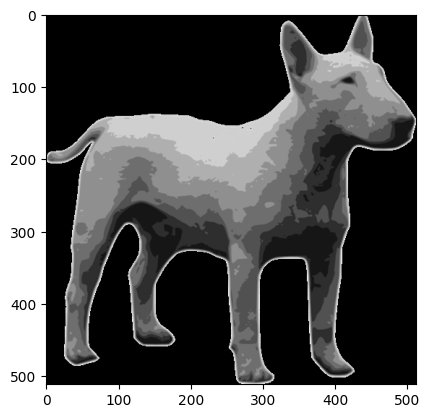

In [5]:
plt.imshow(image, cmap="gray")

In [6]:
M, N = image.shape

# Method Parameters
**B** - Block Size
- determines the visual effect of the encrypted images and the data embedding performance of the encrypted images.

**r** - Required Images
- required number of encrypted images to recover the original image.

**n** - Total Images
- the total number of encrypted images.

**enc_key** - The Encryption key
- the main encryption key used for our image encryption, data encryption and seeding for random number generation so it is reproduceable

In [7]:
r = 3
n = 3

B = 8

In [8]:
enc_key = secrets.randbits(32)
enc_key

3059784434

# Encryption
## Paramters
**F** - Prime number that any rxr sub-matrix of the (r,n)-threshold MSS is coprime with.

In [9]:
F = 257

In [10]:
def generate_coefficient_matrix(enc_key, block, n, r, F):
    np.random.seed(enc_key + block)

    q = np.random.choice(range(1,F), size=n)
    p = np.random.choice(range(1,F), size=n, replace=False)

    X = np.zeros((n, r), dtype=int)
    X[:, 0] = q

    for j in range(1, r):
        for i in range(n):
            X[i][j] = X[i][j-1] * ((p[i] + j - 1)%F) % F

    return X

In [11]:
def scramble_image(image_blocks, enc_key):
    np.random.seed(enc_key)
    num_blocks = len(image_blocks)

    rand_seq = np.random.permutation(num_blocks)
    #print(rand_seq)
    index_vector = np.argsort(rand_seq)

    scrambled = [image_blocks[i] for i in index_vector]
    
    return scrambled

In [12]:
def threshold_share(X, IB_j, a1, a2, F):
    a = np.concatenate(([IB_j, a1], a2))
    f_j = np.dot(X, a) % F
    #print(X, a, f_j)

    return f_j

    
def encrypt_image_blocks(image_blocks, enc_key, n, r, F):
    num_blocks = len(image_blocks)
    X_arr = [generate_coefficient_matrix(enc_key, i, n, r, F) for i in range(num_blocks)]
    #print(X_arr[91])

    #init shared result for first section fd(0)
    np.random.seed(enc_key)
    prev_shares = np.random.randint(0, F, size=n)
    a2 = np.random.randint(0, F, r-2)
    
    encrypted_shares = []

    for block_ind in range(num_blocks):
        IB = image_blocks[block_ind].flatten()
        block_shares = []
        for i, pixel in enumerate(IB):
            if(i == 0):
                a1 = np.random.randint(0, F)
            else:
                a1 = np.random.choice(prev_shares)
            
            f_j = threshold_share(X_arr[block_ind], pixel, a1, a2, F)
            prev_shares = f_j
            
            block_shares.append(f_j)

        encrypted_shares.append(block_shares)
    
    return encrypted_shares

def encrypt_image(image, enc_key, n, r, B):
    M, N = image.shape

    image_blocks = [image[i:i+B, j:j+B] for i in range(0, M, B) for j in range(0, N, B) ]
    image_blocks = scramble_image(image_blocks, enc_key)

    encrypted_shares = encrypt_image_blocks(image_blocks, enc_key, n, r, F)

    return encrypted_shares

#generate n images from the shares
def n_image_from_shares(shares, n, B, M, N):
    BM = [[] for _ in range(n)]
    n_blocks = [[] for _ in range(n)]
    for block_ind in range(len(shares)):
        block = shares[block_ind]
        blocks = np.zeros((n, B*B), dtype=int)
        block_BM = np.zeros((n, B*B), dtype=int)
        for pixel in range(len(block)):
            for n_share in range(n):
                pixel_value = block[pixel][n_share]

                block_BM[n_share, pixel] = int(pixel_value == 256)
                if(pixel_value) == 256:
                    if(pixel == 0):
                        pixel_value = 255
                    else:
                        pixel_value = block[pixel-1][n_share]
                   
                blocks[n_share, pixel] = pixel_value
        
        for i in range(n):
            BM[i].append(block_BM[i].reshape((B,B)))
            n_blocks[i].append(blocks[i].reshape((B, B)))
    
    n_blocks = np.array(n_blocks)
    BM = np.array(BM)
    
    n_BM = [] #n x (M, N) bitmap storing previous locations of value 256
    n_enc_images = [] #n x (M, N) encrypted images
    for i in range(n):
        n_BM.append(BM[i].reshape(M, N))
        n_enc_images.append(n_blocks[i].reshape(M, N))
    
    return np.array(n_enc_images), np.array(n_BM)

In [13]:
shares = encrypt_image(image, enc_key, n, r, B)

In [14]:
enc_images, BMs = n_image_from_shares(shares, n, B, M, N)

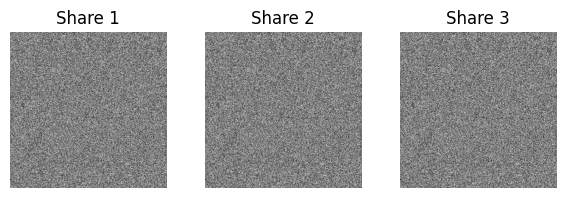

In [15]:
def plot_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images, cmap='gray', vmin=0, vmax=255)
            ax.set_title(f'Share {i+1}')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

rows = 1
cols = n
plot_images(enc_images[1], rows, cols)

# Post Processiong

In [468]:
def LSB(num):
    return int(num) & 1

In [22]:
from arithmetic_compressor import AECompressor
from arithmetic_compressor.models import MultiPPM
from math import ceil, log2
import time

def run_length_encode(data):
    encoded_data = []
    count = 1

    for i in range(1, len(data)):
        if data[i] == data[i - 1]:
            count += 1
        else:
            encoded_data.extend([data[i - 1], count])
            count = 1

    encoded_data.extend([data[-1], count])
    return encoded_data

def arith_encode(data):
    model = MultiPPM([0,1],10)
    coder = AECompressor(model)
    return coder.compress(data)

def run_length_decode_array(encoded_array):
    decoded_array = []

    for i in range(0, len(encoded_array), 2):
        value = encoded_array[i]
        count = encoded_array[i + 1]

        # Append the value to the decoded array repeated count times
        decoded_array.extend([value] * count)

    return decoded_array

def compare_encoding(data):
    run_start = time.time()
    run_len = len(run_length_encode(data))
    run_end = time.time()

    arith_start = time.time()
    arith_len = len(arith_encode(data))
    arith_end = time.time()

    orig_len = len(data)
    print("Original Length: ", orig_len)
    print("")
    print("Run Length Encoding:")
    print("Encoded Length: ", run_len)
    print("Time Elapsed (seconds): ", run_end-run_start)
    print("")
    print("Arithmetic Coding:")
    print("Encoded Length: ", arith_len)
    print("Time Elapsed (seconds): ", arith_end-arith_start)
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")

def compress_bitmap(BM):
    zero_count = BM.size - np.count_nonzero(BM)
    compressed = run_length_encode(BM.flatten())
    
    return (compressed, zero_count)
        
def uncompress_bitmap(CBM, M, N):
    BM = run_length_decode_array(CBM)
    return BM.reshape((M, N))

def LSB_embed(image, CBM, zero_count, B, r, image_identity):
    M, N = image.shape

    CBM_bits = ceil(log2(M*N))
    encoded_CBM_len = format(len(CBM), f"0{CBM_bits}b")
    encoded_zero_cnt = format(zero_count, f"0{CBM_bits}b")

    blocksize_bits = 8
    encoded_block_size = format(B, f"0{blocksize_bits}b")

    r_bits = 8
    encoded_r = format(r, f"0{r_bits}b")

    identity_bits = 8
    encoded_identity_bits = format(image_identity, f"0{identity_bits}b")

    information_stream = encoded_CBM_len + encoded_zero_cnt + encoded_block_size + encoded_r + encoded_identity_bits
    
    orig_lsb = []
    cnt = 0
    i = M-1
    j = N-1
    while cnt < len(information_stream):
        val = image[i, j]
        orig_lsb.append(LSB(val))
        val_bin = format(val, f"08b")
        image[i, j] = int(val_bin[:-1] + information_stream[cnt], 2)
        cnt+=1
        j-=1
        if(j < 0):
            j=N-1
            i-=1

    return image, orig_lsb

In [20]:
#generate Compressed bitmaps
CBMs = []
for BM in BMs:
    CBMs.append(compress_bitmap(BM))

In [471]:
# embed side information
orig_LSBs = []
for i in range(len(enc_images)):
    enc_images[i], lsbs = LSB_embed(enc_images[i], CBMs[i][0], CBMs[i][1], B, r, i)
    orig_LSBs.append(np.array(lsbs))

In [23]:
for BM in BMs:
    compare_encoding(BM.flatten())

Original Length:  262144

Run Length Encoding:
Encoded Length:  4034
Time Elapsed (seconds):  0.07288908958435059

Arithmetic Coding:
Encoded Length:  11007
Time Elapsed (seconds):  24.075805187225342
~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original Length:  262144

Run Length Encoding:
Encoded Length:  3870
Time Elapsed (seconds):  0.05225539207458496

Arithmetic Coding:
Encoded Length:  10671
Time Elapsed (seconds):  23.733716011047363
~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original Length:  262144

Run Length Encoding:
Encoded Length:  4114
Time Elapsed (seconds):  0.05023527145385742

Arithmetic Coding:
Encoded Length:  11157
Time Elapsed (seconds):  23.180333852767944
~~~~~~~~~~~~~~~~~~~~~~~~~~~


for BM in BMs:
    compress_bitmap(BM)


## Difference Expansion

In [472]:
from bitstring import BitArray

bin_loc_map_end = '110110011011'

In [473]:
def run_length_encode(data):
    encoded_data = []
    count = 1

    for i in range(1, len(data)):
        if data[i] == data[i - 1]:
            count += 1
        else:
            encoded_data.extend([data[i - 1], count])
            count = 1

    encoded_data.extend([data[-1], count])
    return encoded_data

In [474]:

def pair_and_transform(image):
    pairs = [(image[i, 2 * j - 1], image[i, 2 * j]) for i in range(image.shape[0]) for j in range(image.shape[1] // 2)]
    differences = [[np.floor((x + y) / 2), x - y] for x, y in pairs]
    return differences    

def is_expandable(l, h):
    l_roof = min(2*(255-l), 2*l +1)
    return abs(2*h) <= l_roof and abs(2*h+1) <= l_roof

def is_changeable(l, h):
    l_roof = min(2*(255-l), 2*l +1)
    return abs(2*np.floor(h/2)) <= l_roof and abs(2*np.floor(h/2) + 1)

def partition_differences(differences):
    EZ = [h for l, h in differences if ((h == 0 or h == -1) and is_expandable(l, h))]
    EN = [h for l, h in differences if ((h != 0 and h != -1) and is_expandable(l, h))]
    CN = [h for l, h in differences if (not is_expandable(l, h) and is_changeable(l, h))]
    NC = [h for l, h in differences if (not is_changeable(l, h))]

    return EZ, EN, CN, NC
    

def create_location_map(EZ, EN1, diff_pairs, fast=False):
    location = []
    if(fast):
        location = [1 if is_expandable(l, h) else 0 for l,h in diff_pairs]
    else:
        zoom = set(EZ + EN1)
        location = [1 if h in zoom else 0 for _,h in diff_pairs]    
    compressed = run_length_encode(location)
    return compressed

# tune selection
def adjust_EN_selection(EN1, EN2, payload_size, compressed_location_map_size):
    # Fine-tune the selection by flipping some expandable difference values
    # from EN1 to EN2 to meet the payload size constraint
    difference = (len(EN1) + len(EN2) + payload_size - compressed_location_map_size) // 2
    if difference > 0:
        # Flip the first 'difference' elements from EN1 to EN2
        EN1_adjusted = EN1[difference:]
        EN2_adjusted = EN2 + EN1[:difference]
    else:
        EN1_adjusted = EN1
        EN2_adjusted = EN2

    return EN1_adjusted, EN2_adjusted

def find_optimal_threshold(EZ, EN, CN, payload_size, diff, compressed_location_map_size):
    optimal_threshold = 1  # Start with a small threshold
    EN1_optimal, EN2_optimal = partition_EN_with_threshold(EN, optimal_threshold)
    # Increase the threshold until Condition (5) is met
    while payload_size > len(EZ) + len(EN1_optimal) + len(EN2_optimal+CN) - compressed_location_map_size:
        optimal_threshold += 1
        EN1_optimal, EN2_optimal = partition_EN_with_threshold(EN, optimal_threshold)
        compressed_location_map_size = len(create_location_map(EZ, EN1_optimal, diff))*6

    # Fine-tune the selection by flipping some expandable difference values
    # from EN1 to EN2 to meet the payload size constraint
    EN1_optimal, EN2_optimal = adjust_EN_selection(EN1_optimal, EN2_optimal, payload_size, compressed_location_map_size)

    return optimal_threshold, EN1_optimal, EN2_optimal

def partition_EN_with_threshold(EN, threshold):
    EN1 = [h for h in EN if abs(h) <= threshold]
    EN2 = [h for h in EN if abs(h) > threshold]

    return EN1, EN2

def collect_LSB(EN2, CN):
    C = []
    for h in set(EN2+CN):
        if abs(h) != 1 and abs(h) != 2:
            C.append(LSB(h))
    
    return C

def to_bitstream(arr):
    bs = BitArray()
    for i in arr:
        bs.append(BitArray(uint=i, length=8))
    return bs

def payload_bitstream(arr):
    bs = BitArray()
    for i in arr:
        bs.append(BitArray(uint=i, length=12))
    return bs

def len_map_bitstream(arr):
    bs = BitArray()
    for i in range(0, len(arr), 2):
        #print(arr[i])
        bs.append(BitArray(uint=arr[i], length=1))
        bs.append(BitArray(uint=arr[i+1], length=11))
    bs.append(BitArray(bin=bin_loc_map_end))
    return bs

def data_embed(image, payload, T=None):
    M, N = image.shape
    diff = pair_and_transform(image)
    EZ, EN, CN, NC = partition_differences(diff)

    if(T is None):
        init_lmap = create_location_map(EZ, EN, diff, fast=True) #create initial location map

        T, EN1, EN2 = find_optimal_threshold(EZ, EN, CN, len(payload)*10, diff, len(init_lmap)*6)
    else:
        EN1, EN2 = partition_EN_with_threshold(EN, T)

    comp_lmap = create_location_map(EZ, EN1, diff)

    lsbs_C = collect_LSB(EN2, CN)

    L = len_map_bitstream(comp_lmap)#1 - 11 .... 12
    C = to_bitstream(lsbs_C)#8bits
    P = payload_bitstream(payload) # 12 bits
    
    B = L + C + P 

    # Initialize indices
    i = 0
    j = 0

    # Iterate through each bit of B for data embedding
    s1 = set(EZ + EN1)
    s2 = set(EN2 + CN)
    while i < len(B):
        j += 1

        # Get the current difference value hj
        l, hj = diff[j]

        # Update hj based on its set
        if hj in s1 and is_expandable(l, hj):
            hj = 2 * hj + B[i]
            i += 1
        elif hj in s2:
            hj = 2 * (hj // 2) + B[i]
            i += 1

        diff[j][1] = hj

    new_image = np.zeros((M, N))
    diff_ind = 0
    for i in range(M):
        for j in range(N//2):
            x_ind = (i, 2*j-1)
            y_ind = (i, 2*j)
            l, h = diff[diff_ind]
            x = l+np.floor((h+1)/2)
            y= l-np.floor(h/2)
            new_image[x_ind[0], x_ind[1]] = x
            new_image[y_ind[0], y_ind[1]] = y
            diff_ind+=1
    
    return new_image


In [475]:
DE_image = []
for i in range(len(enc_images)):
    enc_image = enc_images[i]
    CBM = CBMs[i][0]
    orig_bits = orig_LSBs[i]   
    CBM = np.concatenate([CBM, orig_bits]) 
    DE_image.append(data_embed(enc_image, CBM))

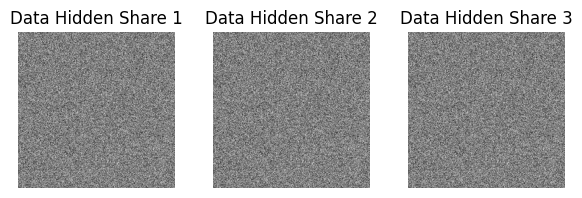

In [476]:
def plot_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images, cmap='gray', vmin=0, vmax=255)
            ax.set_title(f'Data Hidden Share {i+1}')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

rows = 1
cols = n
plot_images(DE_image[1], rows, cols)

# Image Retreival

In [40]:
def unscramble_image(image_blocks, enc_key):
    np.random.seed(enc_key)
    num_blocks = len(image_blocks)

    rand_seq = np.random.permutation(num_blocks)

    unscrambled = [image_blocks[i] for i in rand_seq]
    
    return unscrambled

def decrypt_image(image_ids, r_images, enc_key, B, n, r, F):
    M, N = r_images[0].shape
    shares = []
    rec_image = []
    image_blocks = np.array([[image[i:i+B, j:j+B] for i in range(0, M, B) for j in range(0, N, B) ] for image in r_images])
    
    num_blocks = math.ceil((M*N)/(B*B))

    X_arr = [generate_coefficient_matrix(enc_key, i, n, r, F) for i in range(num_blocks)]

    for block_ind in range(num_blocks):
        block = np.array([image_blocks[i][block_ind].flatten() for i in range(len(r_images))])
        X = X_arr[block_ind]
        #print(block_ind)
        X_r = np.array([X[i,:] for i in image_ids])
        #print(X_r)
        X_r_inv = np.linalg.inv(X_r)
        rec_block = []
        for pixel_ind in range(B*B):
            shares = np.array([block[i][pixel_ind] for i in range(len(block))])
            rec_block.append(np.dot(X_r_inv, shares)[0])
            print(shares)
            print(np.dot(X_r_inv, shares))
            print(X_r)
        rec_block = np.array(rec_block)
        rec_image.append(rec_block.reshape(B*B));

    unscrambled = np.array(unscramble_image(rec_image, enc_key))
    unencrypted = unscrambled.reshape(M,N)

    return unencrypted
    

In [ ]:
dec = decrypt_image(list(range(3)), enc_images, enc_key, B, n, r, F)